In [1]:
# Import dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sqlalchemy import create_engine
from config import user, db_password, host, database

In [2]:
# Create the database engine
engine = create_engine(f"postgres://{user}:{db_password}@{host}:5432/{database}")

In [3]:
# Import flu and uninsured rates from database
uninsured_rates_df = pd.read_sql_query("SELECT * FROM uninsured_rates_by_state", con=engine)
# uninsured_rates_df.head()

flu_df = pd.read_sql_query("SELECT * FROM cleaned_flu_csv", con=engine)
# flu_df.head()

In [4]:
# Merge datasets
uni_flu_df = pd.merge(uninsured_rates_df, flu_df, left_index=True, right_index=True)

uni_flu_df= uni_flu_df.drop(columns="state").copy()

uni_flu_df = uni_flu_df.rename(columns={"\ufeffState": 'state', 
                                        "Uninsured Rate 2016": "uninsured_rate_2016", 
                                        "Uninsured Rate 2017": "uninsured_rate_2017",
                                        "Uninsured Rate 2018": "uninsured_rate_2018",
                                        "Uninsured Rate 2019": "uninsured_rate_2019",
                                        "2016": "flu_cases_2016", 
                                        "2017": "flu_cases_2017", 
                                        "2018": "flu_cases_2018", 
                                        "2019": "flu_cases_2019"})

uni_flu_df.head()

,state,uninsured_rate_2016,uninsured_rate_2017,uninsured_rate_2018,uninsured_rate_2019,flu_cases_2016,flu_cases_2017,flu_cases_2018,flu_cases_2019
0,Alabama,9.1,9.4,10,9.7,11546.0,26878.0,63999.0,68724.0
1,Alaska,14.0,13.7,12,12.2,1063.0,3306.0,8352.0,8249.0
2,Arizona,10.0,10.1,10,11.3,22366.0,22543.0,24574.0,20504.0
3,Arkansas,7.9,7.9,8,9.1,2883.0,5249.0,5831.0,5939.0
4,California,7.3,7.2,7,7.7,44159.0,46097.0,52153.0,52210.0


In [5]:
# Create list of columns in dataframe uni_flu to check names
cols = uni_flu_df.columns.tolist()

In [6]:
# Create dataframe for Linear Regression models
uni_flu_2016_df = uni_flu_df[['state', 'uninsured_rate_2016', 'flu_cases_2016']]
uni_flu_2017_df = uni_flu_df[['state', 'uninsured_rate_2017', 'flu_cases_2017']]
uni_flu_2018_df = uni_flu_df[['state', 'uninsured_rate_2018', 'flu_cases_2018']]
uni_flu_2019_df = uni_flu_df[['state', 'uninsured_rate_2019', 'flu_cases_2019']]

# uni_flu_2016_df['uninsured_rate_2016'] = uni_flu_2016_df.uninsured_rate_2016.astype(int)
# uni_flu_2016_df['flu_cases_2016'] = uni_flu_2016_df.flu_cases_2016.astype(int)
# uni_flu_2017_df['uninsured_rate_2017'] = uni_flu_2017_df.uninsured_rate_2017.astype(int)
# uni_flu_2017_df['flu_cases_2017'] = uni_flu_2017_df.flu_cases_2017.astype(int)
# uni_flu_2018_df['uninsured_rate_2018'] = uni_flu_2018_df.uninsured_rate_2018.astype(int)
# uni_flu_2018_df['flu_cases_2018'] = uni_flu_2018_df.flu_cases_2018.astype(int)
# uni_flu_2019_df['uninsured_rate_2019'] = uni_flu_2019_df.uninsured_rate_2019.astype(int)
# uni_flu_2019_df['flu_cases_2019'] = uni_flu_2019_df.flu_cases_2019.astype(int)

uni_flu_2019_df.dtypes

state                   object
uninsured_rate_2019    float64
flu_cases_2019         float64
dtype: object

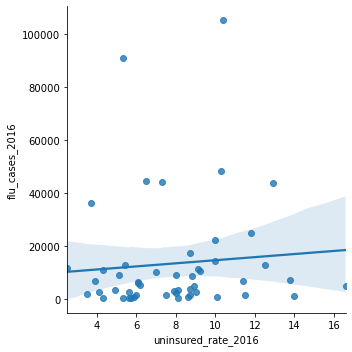

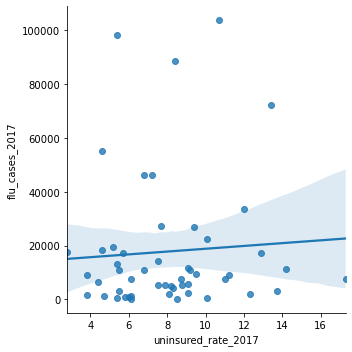

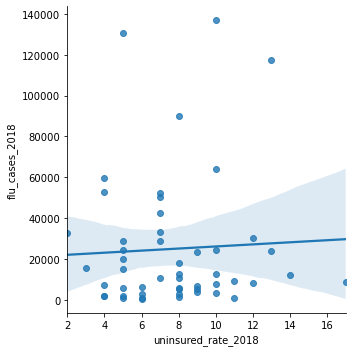

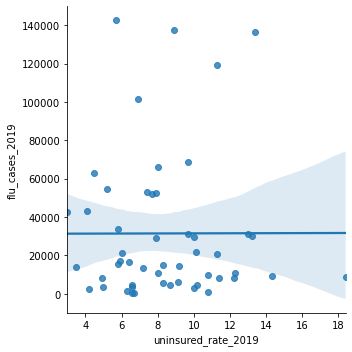

In [7]:
# Explore datasets
fig_2016 = sns.lmplot(x="uninsured_rate_2016", y="flu_cases_2016", data= uni_flu_2016_df)
fig_2017 = sns.lmplot(x="uninsured_rate_2017", y="flu_cases_2017", data= uni_flu_2017_df)
fig_2018 = sns.lmplot(x="uninsured_rate_2018", y="flu_cases_2018", data= uni_flu_2018_df)
fig_2019 = sns.lmplot(x="uninsured_rate_2019", y="flu_cases_2019", data= uni_flu_2019_df)

In [8]:
# Seperate out dependent and independent
# independent variable
X_2016 = uni_flu_2016_df['uninsured_rate_2016'].values.reshape(-1,1)
X_2017 = uni_flu_2017_df['uninsured_rate_2017'].values.reshape(-1,1)
X_2018 = uni_flu_2018_df['uninsured_rate_2018'].values.reshape(-1,1)
X_2019 = uni_flu_2019_df['uninsured_rate_2019'].values.reshape(-1,1)

#dependent variable
y_2016 = uni_flu_2016_df.flu_cases_2016
y_2017 = uni_flu_2017_df.flu_cases_2017
y_2018 = uni_flu_2018_df.flu_cases_2018
y_2019 = uni_flu_2019_df.flu_cases_2019



In [9]:
# Scale data
# Initialize scaler
scaler = StandardScaler()

# fit scaler to data
X_2016_scaled = scaler.fit_transform(X_2016)
X_2017_scaled = scaler.fit_transform(X_2017)
X_2018_scaled = scaler.fit_transform(X_2018)
X_2019_scaled = scaler.fit_transform(X_2019)

In [10]:
# Build Linear regression model
model = LinearRegression()

# Fit model for 2016
lin_reg_2016 = model.fit(X_2016_scaled, y_2016)
lin_reg_2017 = model.fit(X_2017_scaled, y_2017)
lin_reg_2018 = model.fit(X_2018_scaled, y_2018)
lin_reg_2019 = model.fit(X_2019_scaled, y_2019)

# score model for 2016 linear regression
lin_reg_2016.score(X_2016_scaled, y_2016)
lin_reg_2017.score(X_2017_scaled, y_2017)
lin_reg_2018.score(X_2018_scaled, y_2018)
lin_reg_2019.score(X_2019_scaled, y_2019)

3.6813849711991864e-06

In [ ]:
# Plot the simple linear regressions


In [ ]:
# Run a multiple linear regression
